<p style="font-size: 3em; font-weight: bold; margin-top: 0.5em; margin-bottom: 1em;">Data splits for TCO-18 dataset</p>

# Notes

* We use the TCO-18 dataset as used for the NOMAD Kaggle challenge
* Differences between this dataset and the BA10-18 dataset:
  * one order of magnitude less systems
  * fewer chemical elements
  * two properties
  * more space groups
  * only "approximate" geometries
* Data selection key points:
  * propery is energy of formation, that is linear part subtracted already
  * we do not use band gap for now
  * same validation set size as in Kaggle challenge (600 systems)
  * seven training sets, sizes equi-spaced in log-space
  * four of these are the same as for gdb9-14 and ba10-18, the three additional ones are in-between
  * stratification criteria: 
    * formation energy per atom
    * band gap
    * space group
    * size (number of atoms in the unit cell)
    * elements
  * 10 outer validation sets and outer training sets. 
    each training set is split 10 times into inner training and validation sets,
    with a ratio of 80:20

In [2]:
valsetsize = 600
trainsetsizes = [100, 160, 250, 400, 650, 1000, 1600]

# Import libraries

In [1]:
%autosave 0

import sys, os, os.path
import zipfile, bz2, csv, re
import copy, random, math

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import IPython

sys.path.insert(0, '../../../../Projects/qmmlpack/python')  # local development version
import qmmlpack as qmml

Autosave disabled


# Load dataset

In [3]:
dsfile = '../../../../Projects/QMMLPage/Datasets/tco-18/dataset/tco-18_v1.zip'
with zipfile.ZipFile(dsfile) as zf:
    readme = zf.read('readme.txt').decode('ascii')
    v1test_raw = zf.read('tco_test.txt').decode('ascii')
    v1train_raw = zf.read('tco_training.txt').decode('ascii')

In [4]:
def importds(s):
    """Import (parse) dataset in v1 format."""
    
    def to_list(arg, type_):
        """Parse list of whitespace-separated entries of given type."""
        return [type_(i) for i in arg.split()]
    
    rx_material = re.compile(
        r'--- \d+ ---\n'
        r'Formation energy \(eV/atom\) =\s*(?:-?\d+.\d+[ ]?)\s*\n'
        r'Band gap \(eV\) =\s*(?:-?\d+.\d+[ ]?)\s*\n'
        r'Space group =\s*\d+\s*\n'
        r'Atomic numbers = (?:\d+\s*)+\n'
        r'Atom coordinates = \s*\n(?:\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*\n)+'
        r'Basis =\s*\n(?:\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*\n){3}'
    )
    
    rx_id = re.compile(r'--- (\d+) ---\n')
    rx_fe_nsubst = re.compile(r'Formation energy \(eV/atom\) =\s*(-?\d+.\d+[ ]?)\s*\n')
    rx_bandgap = re.compile(r'Band gap \(eV\) =\s*(-?\d+.\d+[ ]?)\s*\n')
    rx_spacegroup = re.compile(r'Space group =\s*(\d+)\s*\n')
    rx_atoms = re.compile(r'Atomic numbers = ((\d+\s*)+)\n')
    rx_coords = re.compile(r'Atom coordinates = \s*\n((?:\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*\n)+)')
    rx_basis = re.compile(r'Basis =\s*\n((?:\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*(?:-?\d+.\d+[ ]?)\s*\n){3})')

    id_, fe_nsubst, bandgap, spacegroup, atoms, coords, basis = [], [], [], [], [], [], []
    for m in rx_material.findall(s):
        _id_ = int( rx_id.search(m).group(1) )
        _fe_nsubst = float( rx_fe_nsubst.search(m).group(1) )
        _bandgap = float( rx_bandgap.search(m).group(1) )
        _spacegroup = int( rx_spacegroup.search(m).group(1) )
        _atoms = to_list( rx_atoms.search(m).group(1), type_=int )
        _atoms = np.asarray( _atoms, dtype=int )
        _coords = to_list( rx_coords.search(m).group(1), float )
        _coords = np.asfarray( _coords ).reshape( (-1,3) )
        _basis = to_list( rx_basis.search(m).group(1), type_=float )
        _basis = np.asfarray( _basis ).reshape( (-1,3) )
        
        id_.append(_id_)
        fe_nsubst.append(_fe_nsubst)
        bandgap.append(_bandgap)
        spacegroup.append(_spacegroup)
        atoms.append(_atoms)
        coords.append(_coords)
        basis.append(_basis)
        
    id_ = np.asarray(id_, dtype=int)
    fe_nsubst = np.asfarray(fe_nsubst)
    bandgap = np.asfarray(bandgap)
    spacegroup = np.asarray(spacegroup, dtype=int)
    atoms = np.asarray(atoms)
    coords = np.asarray( coords )
    basis = np.asarray( basis )
    
    # number of substitution sites
    nsubst = np.asarray( [len(a)-np.count_nonzero(a == 8) for a in atoms], dtype=int )
    
    # the formation energy in the original files is per substitution site (although wronly labelled)
    # compute formation energy per atom
    num_atoms = np.asarray( [len(a) for a in atoms], dtype=int )
    fe_natom = ( fe_nsubst * nsubst ) / num_atoms
    
    return {
        'id': id_, 
        'fe/subst': fe_nsubst, 
        'bandgap': bandgap, 
        'spacegroup': spacegroup, 
        'atomic_numbers': atoms, 
        'coordinates': coords, 
        'basis': basis,
        # derived quantities
        'nsubst': nsubst,
        'fe/atom': fe_natom
    }

In [5]:
ds_train = importds(v1train_raw);
ds_test = importds(v1test_raw);

In [6]:
def joinds(aa, bb):
    """Joins two v1 datasets."""
    
    def join(a, b):
        assert a.shape[1:] == b.shape[1:]
        cshape = list(a.shape); 
        cshape[0] += b.shape[0]
        c = np.concatenate( (a, b), axis=0 )
        assert c.shape == tuple(cshape)
        return c
    
    assert aa.keys() == bb.keys()
    
    return { k: join(aa[k], bb[k]) for k in aa.keys() }

data = joinds(ds_train, ds_test)

Properties

In [7]:
# sizes of unit cells
# alloys are not saturated, and there is therefore no difference between sizes with and without hydrogens
data['sizes'] = np.asarray( [len(a) for a in data['atomic_numbers']], dtype=int )

# eV -> meV
data['fe/atom/meV'] = data['fe/atom'] * 1000

# Analyse dataset

In [13]:
qmml.dataset_information(**data)

{'is_periodic': True,
 'num_systems': 3000,
 'num_atoms': 185070,
 'max_atoms_per_system': 80,
 'elements': array([ 8, 13, 31, 49]),
 'max_elements_per_system': 4,
 'max_same_element_per_system': 48,
 'systems_per_element': array([   0,    0,    0,    0,    0,    0,    0,    0, 3000,    0,    0,
           0,    0, 2584,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 2669,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 2373,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,

## Readme

In [8]:
print(readme)


Nomad2018 Predicting Transparent Conductors
Predict the key properties of novel transparent semiconductors

https://www.kaggle.com/c/nomad2018-predict-transparent-conductors/data

Background
----------

Innovative materials design is needed to tackle some of the most important health, environmental, energy, social, and economic challenges of this century. In particular, improving the properties of materials that are intrinsically connected to the generation and utilization of energy is crucial if we are to mitigate environmental damage due to a growing global demand. Transparent conductors are an important class of compounds that are both electrically conductive and have a low absorption in the visible range, which are typically competing properties. A combination of both of these characteristics is key for the operation of a variety of technological devices such as photovoltaic cells, light-emitting diodes for flat-panel displays, transistors, sensors, touch screens, and lasers. Howe

## Size

Size distribution.

These systems are not saturated with H like the molecules;
there is therefore no distinction between sizes with and without hydrogens.

There are only 6 distinct sizes in this dataset.

In [24]:
uniq_sizes = np.unique(data['sizes'])
print(uniq_sizes)

[10 20 30 40 60 80]


In [27]:
systems_per_size = np.bincount(data['sizes'])
print(np.asarray([
    uniq_sizes, 
    [systems_per_size[i] for i in uniq_sizes], 
    np.cumsum([systems_per_size[i] for i in uniq_sizes])
], dtype=int))

[[  10   20   30   40   60   80]
 [  20  111  399  642   62 1766]
 [  20  131  530 1172 1234 3000]]


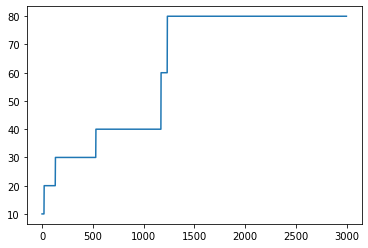

In [28]:
plt.plot( sorted(data['sizes']) ) ; plt.show()

Sizes 10 and 60 are severely underrepresented.

In analogy to the other datasets, we remove all systems with 10 atoms in the unit cell.

The dataset seems too small to drop any of the other groups.

## Properties

In [29]:
np.histogram(data['fe/atom/meV'], 30)[0]

array([103, 163, 218, 240, 263, 266, 231, 261, 283, 229, 195, 127, 111,
       111,  82,  50,  33,  17,   7,   3,   3,   0,   0,   2,   0,   1,
         0,   0,   0,   1])

In [30]:
plt.plot(sorted(data['fe/atom/meV'])); plt.show()

Only very few samples with high energy, but that was the same for BA10-18.

# Sampling code

In [8]:
def poormanssample(size, data, indall, tolerance=0.005, minsize=200, initialbins=30, maxsteps=1000):
    """Samples a stratified subset of given size from molecules.
    
    Parameters:
      size: size of sampled subset
      data: dataset to sample from
      indall: valid indices in dataset to use
      tolerance: base tolerated deviation in each statistic in percent
      minsize: minimum number of systems required in a bin
      initialbins: number of bins to start with
      maxsteps: maximum number of steps taken
      
    Returns:
      indices of subset"""
    
    # ------- setup -------
    
    done = False           # termination condition
    iterations = 0         # iteration counter
    temperature = 0.002    # simulated annealing temperature, on a scale of fractions
    indsel = np.random.choice(indall, size, replace=False) # initial random sample
    history = np.asfarray( [[0,0,0,0,0,0]] )
    
    # statistics to consider
    # each function f(value, mols, ind) returns those positions in ind 
    # for which the statistic takes on the given value
    def fel(el, ind):
        return np.nonzero( np.asarray( [1 if el in an else 0 for an in data['atomic_numbers'][ind]] ) )[0]
    def fsize(s, ind):
        return np.nonzero( np.asarray( [1 if len(an) == s else 0 for an in data['atomic_numbers'][ind]] ) )[0]
    def fE(s, ind):
        return np.nonzero( np.asarray( [1 if s[0] <= e < s[1] else 0 for e in data['fe/atom/meV'][ind]] ) )[0]
    
    # statistics functions
    # these define the statistics which are compared between sample and whole dataset
    # entries are (statfunction, value, name)
    statfuns = [
        # elemental composition
        [fel, 13, 'Al'],
        [fel, 31, 'Ga'],
        [fel, 49, 'In'],
        [fel,  8, 'O' ],
        
        # size
        # size 10 has been excluded
        [fsize, 20, "s-20"],
        [fsize, 30, "s-30"],
        [fsize, 40, "s-40"],
        [fsize, 60, "s-60"],
        [fsize, 80, "s-80"],
    ]

    # energy statistics
    enums,ebins = np.histogram(data['fe/atom/meV'][indall], initialbins)
    while len(enums) > 1 and min(enums) < minsize: # lump together bins that are too small
        for i in range(len(enums)):
            if enums[i] < minsize:
                if i == len(enums)-1: i = i - 1  # special case of merging last entry
                enums[i] += enums[i+1]
                enums = np.delete(enums, [i+1])
                ebins = np.delete(ebins, [i+1])
                break
    for i in range(1,len(ebins)):
        statfuns.append( [fE, (ebins[i-1], ebins[i]), f"E-{i:2}"] )

    statfuns, numstatfuns = np.asarray(statfuns), len(statfuns)
    print(f"{numstatfuns:d} statistics in total, {len(ebins):d} energy bins.\n")
    
    # ------- Monte Carlo loop -------
    
    def step(sf, dev, aux):
        nonlocal done, indsel
        indstatall, indstatsel, pcall, pcsel, name = aux

        # check if within tolerance, correct if not
        if pcall - pcsel > tolerance: 
            # add molecule with this statistic
            done = False
            i = np.random.choice( np.setdiff1d(np.arange(size), indstatsel) ) # index of molecule without statistic
            indsel[i] = np.random.choice( np.setdiff1d(indall[indstatall], indsel) ) # add molecule with statistic
            print(f"{name:7}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> adding structure")
        elif pcsel - pcall > tolerance: 
            # remove molecule with this statistic
            done = False
            i = np.random.choice(indstatsel)  # index of molecule with statistic
            indsel[i] = np.random.choice( np.setdiff1d(indall[np.setdiff1d(np.arange(len(indall)), indstatall)], indsel) )  # add molecule without statistic          
            print(f"{name:5}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> removing structure")
        else:  
            # within tolerance, do nothing
            print(f"{name:5}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> okay")

    def update_devaux():
        nonlocal deviations, auxiliary
        for i in range(numstatfuns):
            indstatall = statfuns[i,0](statfuns[i,1], indall)
            indstatsel = statfuns[i,0](statfuns[i,1], indsel)
            pcall, pcsel = len(indstatall)/len(indall), len(indstatsel)/size
            deviations[i] = max( abs(pcall-pcsel), 10**-6 )  # ensure positive probabilities
            auxiliary[i] = (indstatall, indstatsel, pcall, pcsel, statfuns[i,2])

    deviations = np.full(numstatfuns, 1, dtype=np.float)
    auxiliary = np.full((numstatfuns, 5), None, dtype=np.object)
    update_devaux()
    bestdeviations, bestindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
    lastdeviations, lastindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
    while not done:
        # update loop statistics
        history = np.append(history, [[np.mean(deviations), np.max(deviations), np.mean(lastdeviations), np.max(lastdeviations), np.mean(bestdeviations), np.max(bestdeviations)]], axis=0)
        lastdeviations, lastauxiliary, lastindsel = copy.deepcopy(deviations), copy.deepcopy(auxiliary), copy.deepcopy(indsel)
        iterations += 1
        done = True
        print(f"Iteration {iterations}   (best so far: {np.mean(bestdeviations):6.2%} {np.max(bestdeviations):6.2%})")
        
        # shuffle with largest deviations weighted up, then propose move
        probabilities = deviations / np.sum(deviations)
        shuffleind = np.random.choice(numstatfuns, size=numstatfuns, replace=False, p=probabilities)
        statfuns, deviations, auxiliary = statfuns[shuffleind], deviations[shuffleind], auxiliary[shuffleind]
        for sf,d,a in zip(statfuns, deviations, auxiliary):
            if not done: break
            step(sf, d, a)

        # update deviations, auxiliary
        update_devaux()
            
        # accept or reject proposed move
        if np.max(deviations) < np.max(bestdeviations) or (np.max(deviations) == np.max(bestdeviations) and np.mean(deviations) < np.mean(bestdeviations)):
            bestdeviations, bestindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
        print(f"Last: {np.mean(lastdeviations):6.2%} {np.max(lastdeviations):6.2%}.   Current: {np.mean(deviations):6.2%} {np.max(deviations):6.2%}")
        if ( np.max(deviations) > np.max(lastdeviations) ) or \
           ( np.max(deviations) == np.max(lastdeviations) and np.mean(deviations) > np.mean(lastdeviations) ):
            probability = math.exp( - ( 3 * ( np.max(deviations) - np.max(lastdeviations) ) + ( np.mean(deviations) - np.mean(lastdeviations) ) ) / temperature )
            if np.random.random() <= probability:
                print(f"Acceptance probability: {probability:6.2%} -> accepting uphill step.")
            else:
                print(f"Acceptance probability: {probability:6.2%} -> rejecting uphill step.")
                deviations, auxiliary, indsel = copy.deepcopy(lastdeviations), copy.deepcopy(lastauxiliary), copy.deepcopy(lastindsel)
        print()
        
        if iterations >= maxsteps:
            done = True

    # print last statistics again in sorted order
    sortind = np.argsort(statfuns[:,2])
    statfuns, deviations, auxiliary = statfuns[sortind], deviations[sortind], auxiliary[sortind]
    for sf,d,a in zip(statfuns, deviations, auxiliary):
        print(f"{sf[2]:5s}: {d:6.2%}")
    print()
            
    if iterations < maxsteps:
        print(f"All statistics met, done ({iterations} iterations).")
    else:
        print(f"MAXIMUM NUMBER OF {maxsteps:d} ITERATIONS REACHED, ABORTING")
    print(f"Best solution has average deviation {np.mean(bestdeviations):6.2%} and max. deviation {np.max(bestdeviations):6.2%}.")

    history = np.delete(history, 0, 0)
    history = np.delete(history, 0, 0)

    return bestindsel, bestdeviations, history

Test code:

In [32]:
valid = np.arange(len(data['fe/atom/meV']))
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if data['sizes'][i] == 10]))

In [ ]:
t, tdev, thist = poormanssample(1000, data, valid2, maxsteps=5)

In [ ]:
plt.plot(thist[:,0]*100, label='avg/current')
plt.plot(thist[:,1]*100, label='max/current')
plt.plot(thist[:,4]*100, label='avg/best')
plt.plot(thist[:,5]*100, label='max/best')
plt.xlabel('iterations')
plt.ylabel('deviation / %')
plt.legend()
plt.show()

In [ ]:
t, tdev, thist = poormanssample(100, data, valid2, maxsteps=400)

In [ ]:
plt.plot(thist[:,0]*100, label='avg/current')
plt.plot(thist[:,1]*100, label='max/current')
plt.plot(thist[:,4]*100, label='avg/best')
plt.plot(thist[:,5]*100, label='max/best')
plt.xlabel('iterations')
plt.ylabel('deviation / %')
plt.legend()
plt.show()

# Generate subsets

In [8]:
filename = 'tco-18-datasplits.txt'

In [9]:
def run_sampling(valid, size, key, tolerance, maxsteps):
    """Samples a data subset.
    
    Parameters:
      valid - universe of indices to choose from
      size - number of indices in sampled subset
      key - string name of the sampled subset
      tolerance - tolerated deviation from whole-set statistics
      maxsteps - maximum number of Monte Carlo steps
    """
    # run sampling
    ind, dev, hist = poormanssample(size, data, valid, tolerance=tolerance, maxsteps=maxsteps)

    # write results to file, appending
    with open(filename, 'ta', encoding='ascii') as f:
        f.write(key + ':' + ' '.join([str(i) for i in ind]) + '\n')
        
    # visualize optimization
    plt.plot(hist[:,0]*100, label='avg/current')
    plt.plot(hist[:,1]*100, label='max/current')
    plt.plot(hist[:,4]*100, label='avg/best')
    plt.plot(hist[:,5]*100, label='max/best')
    plt.xlabel('iterations')
    plt.ylabel('deviation / %')
    plt.legend()
    plt.show()

In [9]:
def load_data_splits(filename):
    with open(filename, 'rt') as f:
        raw = f.read()
    res = {}
    for line in raw.split('\n'):
        if len(line.strip()) == 0: continue
        key, data = line.split(':')
        data = np.asarray( [int(i) for i in data.split()], dtype=int )
        res[key] = data

    return res

## Validation sets

In [14]:
valid = np.arange(len(data['fe/atom/meV']))  # all samples are valid
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if data['sizes'][i] == 10]))

In [25]:
%%time
run_sampling(valid2, valsetsize, 'ov-1', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  0.75%  2.43%)
s-30 : 13.39% - 13.83% = -0.44% -> removing structure
Last:  0.75%  2.43%.   Current:  0.75%  2.43%

...

Iteration 126   (best so far:  0.08%  0.15%)
E- 2 : 10.40% - 10.33% =  0.07% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
E-10 : 14.46% - 14.33% =  0.13% -> okay
E- 1 :  9.43% -  9.33% =  0.10% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
s-20 :  3.72% -  3.83% = -0.11% -> okay
E- 3 : 12.25% - 12.33% = -0.09% -> okay
E- 9 :  6.91% -  7.00% = -0.09% -> okay
E- 5 : 10.70% - 10.83% = -0.13% -> okay
E- 7 :  6.81% -  6.67% =  0.15% -> okay
E- 6 : 12.42% - 12.33% =  0.08% -> okay
s-40 : 21.54% - 21.67% = -0.12% -> okay
s-60 :  2.08% -  2.00% =  0.08% -> okay
E- 4 :  6.71% -  6.83% = -0.12% -> okay
Al   : 86.14% - 86.17% = -0.03% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
La

In [27]:
%%time
run_sampling(valid2, valsetsize, 'ov-2', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  1.24%  2.84%)
E- 2   : 10.40% -  8.50% =  1.90% -> adding structure
Last:  1.24%  2.84%.   Current:  1.25%  2.84%
Acceptance probability: 95.71% -> accepting uphill step.

...

Iteration 121   (best so far:  0.06%  0.15%)
E- 4 :  6.71% -  6.67% =  0.04% -> okay
E- 6 : 12.42% - 12.50% = -0.08% -> okay
s-40 : 21.54% - 21.50% =  0.04% -> okay
E- 7 :  6.81% -  6.67% =  0.15% -> okay
E- 1 :  9.43% -  9.50% = -0.07% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
E- 9 :  6.91% -  7.00% = -0.09% -> okay
s-60 :  2.08% -  2.17% = -0.09% -> okay
E- 3 : 12.25% - 12.33% = -0.09% -> okay
E-10 : 14.46% - 14.33% =  0.13% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
Al   : 86.14% - 86.17% = -0.03% -> okay
s-20 :  3.72% -  3.83% = -0.11% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
Ga   : 89.16% - 89.17% = -0

In [29]:
%%time
run_sampling(valid2, valsetsize, 'ov-3', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  1.24%  3.03%)
E-10 : 14.46% - 15.33% = -0.87% -> removing structure
Last:  1.24%  3.03%.   Current:  1.23%  3.03%

...

Iteration 228   (best so far:  0.06%  0.14%)
s-40 : 21.54% - 21.50% =  0.04% -> okay
E- 3 : 12.25% - 12.17% =  0.08% -> okay
Al   : 86.14% - 86.00% =  0.14% -> okay
E- 9 :  6.91% -  7.00% = -0.09% -> okay
E- 1 :  9.43% -  9.33% =  0.10% -> okay
E- 8 :  9.87% - 10.00% = -0.13% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
E- 6 : 12.42% - 12.33% =  0.08% -> okay
E-10 : 14.46% - 14.50% = -0.04% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
E- 4 :  6.71% -  6.67% =  0.04% -> okay
E- 7 :  6.81% -  6.83% = -0.02% -> okay
s-60 :  2.08% -  2.17% = -0.09% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
s-20 :  3.72% -  3.83% = -0.11% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

In [32]:
%%time
run_sampling(valid2, valsetsize, 'ov-4', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  0.69%  2.09%)
Al   : 86.14% - 87.50% = -1.36% -> removing structure
Last:  0.69%  2.09%.   Current:  0.68%  2.09%

...

Iteration 229   (best so far:  0.07%  0.15%)
E-10 : 14.46% - 14.50% = -0.04% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
E- 4 :  6.71% -  6.67% =  0.04% -> okay
E- 1 :  9.43% -  9.50% = -0.07% -> okay
s-40 : 21.54% - 21.67% = -0.12% -> okay
E- 7 :  6.81% -  6.67% =  0.15% -> okay
Al   : 86.14% - 86.00% =  0.14% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
s-20 :  3.72% -  3.83% = -0.11% -> okay
E- 5 : 10.70% - 10.83% = -0.13% -> okay
E- 9 :  6.91% -  6.83% =  0.08% -> okay
s-60 :  2.08% -  2.00% =  0.08% -> okay
E- 3 : 12.25% - 12.17% =  0.08% -> okay
E- 6 : 12.42% - 12.50% = -0.08% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

In [34]:
%%time
run_sampling(valid2, valsetsize, 'ov-5', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  0.84%  2.25%)
E- 6 : 12.42% - 14.67% = -2.25% -> removing structure
Last:  0.84%  2.25%.   Current:  0.83%  2.10%

...

Iteration 127   (best so far:  0.06%  0.13%)
s-30 : 13.39% - 13.50% = -0.11% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
s-20 :  3.72% -  3.67% =  0.06% -> okay
E- 1 :  9.43% -  9.33% =  0.10% -> okay
E- 3 : 12.25% - 12.33% = -0.09% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
E-10 : 14.46% - 14.33% =  0.13% -> okay
s-60 :  2.08% -  2.00% =  0.08% -> okay
E- 2 : 10.40% - 10.50% = -0.10% -> okay
s-40 : 21.54% - 21.50% =  0.04% -> okay
E- 4 :  6.71% -  6.83% = -0.12% -> okay
E- 6 : 12.42% - 12.33% =  0.08% -> okay
E- 9 :  6.91% -  7.00% = -0.09% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
E- 7 :  6.81% -  6.83% = -0.02% -> okay
s-80 : 59.26% - 59.33% = -0.07% -> okay
Al   : 86.14% - 86.17% = -0.03% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

In [36]:
%%time
run_sampling(valid2, valsetsize, 'ov-6', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  0.99%  2.58%)
E- 7 :  6.81% -  8.50% = -1.69% -> removing structure
Last:  0.99%  2.58%.   Current:  1.01%  2.58%
Acceptance probability: 91.60% -> accepting uphill step.

...

Iteration 122   (best so far:  0.06%  0.15%)
s-20 :  3.72% -  3.83% = -0.11% -> okay
s-80 : 59.26% - 59.33% = -0.07% -> okay
E- 6 : 12.42% - 12.50% = -0.08% -> okay
s-60 :  2.08% -  2.00% =  0.08% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
E- 1 :  9.43% -  9.50% = -0.07% -> okay
E- 4 :  6.71% -  6.83% = -0.12% -> okay
E- 9 :  6.91% -  6.83% =  0.08% -> okay
E- 3 : 12.25% - 12.33% = -0.09% -> okay
E- 7 :  6.81% -  6.67% =  0.15% -> okay
Al   : 86.14% - 86.17% = -0.03% -> okay
E-10 : 14.46% - 14.50% = -0.04% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
s-40 : 21.54% - 21.50% =  0

In [38]:
%%time
run_sampling(valid2, valsetsize, 'ov-7', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  1.15%  3.21%)
E- 3 : 12.25% - 12.67% = -0.42% -> removing structure
Last:  1.15%  3.21%.   Current:  1.11%  3.04%

...

Iteration 229   (best so far:  0.07%  0.15%)
E- 7 :  6.81% -  6.67% =  0.15% -> okay
s-20 :  3.72% -  3.83% = -0.11% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
E- 3 : 12.25% - 12.17% =  0.08% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
Al   : 86.14% - 86.00% =  0.14% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
E- 9 :  6.91% -  6.83% =  0.08% -> okay
E- 6 : 12.42% - 12.33% =  0.08% -> okay
E- 8 :  9.87% - 10.00% = -0.13% -> okay
E- 4 :  6.71% -  6.83% = -0.12% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
s-60 :  2.08% -  2.17% = -0.09% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
s-40 : 21.54% - 21.50% =  0.04% -> okay
E- 1 :  9.43% -  9.50% = -0.07% -> okay
E-10 : 14.46% - 14.50% = -0.04% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

In [40]:
%%time
run_sampling(valid2, valsetsize, 'ov-8', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  0.72%  1.96%)
E- 4 :  6.71% -  8.67% = -1.96% -> removing structure
Last:  0.72%  1.96%.   Current:  0.71%  1.79%

...

Iteration 240   (best so far:  0.06%  0.14%)
s-60 :  2.08% -  2.17% = -0.09% -> okay
E- 4 :  6.71% -  6.67% =  0.04% -> okay
E- 1 :  9.43% -  9.50% = -0.07% -> okay
E- 9 :  6.91% -  6.83% =  0.08% -> okay
Al   : 86.14% - 86.00% =  0.14% -> okay
E- 8 :  9.87% - 10.00% = -0.13% -> okay
E- 7 :  6.81% -  6.83% = -0.02% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
s-40 : 21.54% - 21.67% = -0.12% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
E- 3 : 12.25% - 12.17% =  0.08% -> okay
E-10 : 14.46% - 14.50% = -0.04% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
E- 6 : 12.42% - 12.50% = -0.08% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
s-20 :  3.72% -  3.67% =  0.06% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

In [42]:
%%time
run_sampling(valid2, valsetsize, 'ov-9', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  0.99%  3.30%)
E-10   : 14.46% - 11.50% =  2.96% -> adding structure
Last:  0.99%  3.30%.   Current:  0.99%  3.30%

...

Iteration 193   (best so far:  0.07%  0.15%)
E- 4 :  6.71% -  6.83% = -0.12% -> okay
s-30 : 13.39% - 13.33% =  0.06% -> okay
E- 3 : 12.25% - 12.33% = -0.09% -> okay
s-80 : 59.26% - 59.17% =  0.10% -> okay
E- 7 :  6.81% -  6.67% =  0.15% -> okay
E- 6 : 12.42% - 12.33% =  0.08% -> okay
E- 5 : 10.70% - 10.67% =  0.04% -> okay
Al   : 86.14% - 86.00% =  0.14% -> okay
s-20 :  3.72% -  3.83% = -0.11% -> okay
E- 2 : 10.40% - 10.33% =  0.07% -> okay
E- 9 :  6.91% -  7.00% = -0.09% -> okay
s-60 :  2.08% -  2.17% = -0.09% -> okay
E- 1 :  9.43% -  9.50% = -0.07% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
s-40 : 21.54% - 21.50% =  0.04% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
E-10 : 14.46% - 14.50% = -0.04% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

In [43]:
%%time
run_sampling(valid2, valsetsize, 'ov-10', 0.0015, 2500)


19 statistics in total, 11 energy bins.

Iteration 1   (best so far:  1.06%  4.16%)
E- 9   :  6.91% -  5.83% =  1.08% -> adding structure
Last:  1.06%  4.16%.   Current:  1.04%  3.99%

...

Iteration 214   (best so far:  0.06%  0.13%)
s-60 :  2.08% -  2.00% =  0.08% -> okay
s-30 : 13.39% - 13.50% = -0.11% -> okay
E-10 : 14.46% - 14.33% =  0.13% -> okay
E- 5 : 10.70% - 10.83% = -0.13% -> okay
s-40 : 21.54% - 21.50% =  0.04% -> okay
s-20 :  3.72% -  3.67% =  0.06% -> okay
E- 8 :  9.87% -  9.83% =  0.03% -> okay
s-80 : 59.26% - 59.33% = -0.07% -> okay
E- 1 :  9.43% -  9.33% =  0.10% -> okay
E- 2 : 10.40% - 10.50% = -0.10% -> okay
E- 6 : 12.42% - 12.33% =  0.08% -> okay
E- 4 :  6.71% -  6.67% =  0.04% -> okay
E- 3 : 12.25% - 12.33% = -0.09% -> okay
E- 9 :  6.91% -  7.00% = -0.09% -> okay
E- 7 :  6.81% -  6.83% = -0.02% -> okay
Al   : 86.14% - 86.17% = -0.03% -> okay
Ga   : 89.16% - 89.17% = -0.01% -> okay
In   : 79.16% - 79.17% = -0.01% -> okay
O    : 100.00% - 100.00% =  0.00% -> okay
La

## Outer training sets and internal splits

In [12]:
inds = load_data_splits(filename)
valid = np.arange(len(data['fe/atom/meV']))  # all samples are valid
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if data['sizes'][i] == 10]))
valid3 = [np.setdiff1d(valid2, inds['ov-' + s]) for s in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]

### Outer training sets

In [ ]:
%%time
# 22s
for i in range(10):
    run_sampling(valid3[i], 100, 'ot-' + str(i+1) + '-100', 0.01, 5000)

In [ ]:
%%time
# 42s
for i in range(10):
    run_sampling(valid3[i], 160, 'ot-' + str(i+1) + '-160', 0.005, 5000)

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 250, 'ot-' + str(i+1) + '-250', 0.004, 5000)

In [ ]:
%%time
# 42s
for i in range(10):
    run_sampling(valid3[i], 400, 'ot-' + str(i+1) + '-400', 0.003, 5000)

In [ ]:
%%time
# 47s
for i in range(10):
    run_sampling(valid3[i], 650, 'ot-' + str(i+1) + '-650', 0.002, 5000)

In [ ]:
%%time
# 1m15s
for i in range(10):
    run_sampling(valid3[i], 1000, 'ot-' + str(i+1) + '-1000', 0.001, 5000)

In [ ]:
%%time
# 1m9s
for i in range(10):
    run_sampling(valid3[i], 1600, 'ot-' + str(i+1) + '-1600', 0.001, 5000)

### Inner splits

In [ ]:
%%time
# 45s
for i in range(10):
    for j in range(10):
        run_sampling(inds['ot-' + str(i+1) + '-100'], 20, 'iv-' + str(i+1) + '-100-' + str(j+1), 0.03, 2500)

In [ ]:
%%time
# 19s
for i in range(10):
    for j in range(10):
        run_sampling(inds['ot-' + str(i+1) + '-160'], 32, 'iv-' + str(i+1) + '-160-' + str(j+1), 0.03, 2500)

In [ ]:
%%time
# 21s
for i in range(10):
    for j in range(10):
        run_sampling(inds['ot-' + str(i+1) + '-250'], 50, 'iv-' + str(i+1) + '-250-' + str(j+1), 0.02, 2500)

In [ ]:
%%time
# 35s
for i in range(10):
    for j in range(10):
        run_sampling(inds['ot-' + str(i+1) + '-400'], 80, 'iv-' + str(i+1) + '-400-' + str(j+1), 0.01, 2500)

In [ ]:
%%time
# 43s
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-650'], 130, 'iv-' + str(i+1) + '-650-' + str(j+1), 0.01, 2500)

In [ ]:
%%time
# 1m27s
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-1000'], 200, 'iv-' + str(i+1) + '-1000-' + str(j+1), 0.007, 2500)

In [ ]:
%%time
# 3min2s
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-1600'], 320, 'iv-' + str(i+1) + '-1600-' + str(j+1), 0.005, 2500)

# Validation of sampled subsets

## Validity

In [11]:
inds = load_data_splits(filename)
valid = np.arange(len(data['fe/atom/meV']))  # all samples are valid
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if data['sizes'][i] == 10]))
valid3 = [np.setdiff1d(valid2, inds['ov-' + s]) for s in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]

In [12]:
toosmall = np.asarray([i for i in valid if data['sizes'][i] == 10])
inds = load_data_splits(filename)

numov, numiv = 10, 10

ovkeys = [k for k in inds.keys() if re.fullmatch('ov-\d+', k)]
otkeys = [k for k in inds.keys() if re.fullmatch('ot-\d+-\d+', k)]
ivkeys = [k for k in inds.keys() if re.fullmatch('iv-\d+-\d+-\d+', k)]

assert len(ovkeys) == numov, "all outer validation subsets present"
assert len(otkeys) == numov * len(trainsetsizes), "all training subsets present"
assert len(ivkeys) == numov * len(trainsetsizes) * numiv, "all inner splits present"

In [13]:
print(f"{len(ovkeys):d} outer splits.")
for ov in sorted(ovkeys):
    ovi = ov.split('-')[1]  # index of outer validation set
    
    assert np.unique(inds[ov]).size == inds[ov].size, 'unique entries'
    assert np.intersect1d(inds[ov], toosmall).size == 0, 'excluded due to size'
    print(f"outer validation set {ov} passed.")
    
    for ot in sorted(otkeys):
        oti, otj = ot.split('-')[1:3]  # outer training set indices (ov, tss)
        if oti != ovi: continue

        assert np.unique(inds[ot]).size == inds[ot].size, 'unique entries'
        assert np.intersect1d(inds[ot], toosmall).size == 0, 'excluded due to size'
        assert np.intersect1d(inds[ot], inds['ov-'+oti]).size == 0, "no overlap between training and validation set"
        print(f"    outer training set {ot} passed.")
        
        for iv in sorted(ivkeys):
            ivi, ivj, ivk = iv.split('-')[1:4]
            if ivi != ovi: continue
            if ivj != otj: continue
            
            assert np.unique(inds[iv]).size == inds[iv].size, 'unique entries'
            assert np.in1d(inds[iv], inds[ot]).all(), "split is subset of outer training set"
            assert inds[iv].size == round(inds[ot].size * 0.2), "correct size"
            print(f"        inner validation set {iv} passed.")
            
print("All checks passed.")

10 outer splits.
outer validation set ov-1 passed.
    outer training set ot-1-100 passed.
        inner validation set iv-1-100-1 passed.
        inner validation set iv-1-100-10 passed.
        inner validation set iv-1-100-2 passed.
        inner validation set iv-1-100-3 passed.
        inner validation set iv-1-100-4 passed.
        inner validation set iv-1-100-5 passed.
        inner validation set iv-1-100-6 passed.
        inner validation set iv-1-100-7 passed.
        inner validation set iv-1-100-8 passed.
        inner validation set iv-1-100-9 passed.
    outer training set ot-1-1000 passed.
        inner validation set iv-1-1000-1 passed.
        inner validation set iv-1-1000-10 passed.
        inner validation set iv-1-1000-2 passed.
        inner validation set iv-1-1000-3 passed.
        inner validation set iv-1-1000-4 passed.
        inner validation set iv-1-1000-5 passed.
        inner validation set iv-1-1000-6 passed.
        inner validation set iv-1-1000-7 pa

## Overlap of subsets

Outer validation sets, in percent:

In [29]:
print(np.sort(np.round( [len(np.intersect1d(inds[f'ov-{i+1}'], inds[f'ov-{j+1}']))/valsetsize 
 for i in range(numov) for j in range(numov) if j > i], 2)))

[0.17 0.18 0.18 0.18 0.18 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.19
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.21 0.21 0.21
 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.21 0.22 0.22 0.22 0.22
 0.22 0.22 0.23]


Outer training sets, in percent:

In [32]:
for size in trainsetsizes:
    print(f'i = {size}')
    print(np.sort(np.round( 
        [len(np.intersect1d(inds[f'ot-{i+1}-{size}'], inds[f'ot-{j+1}-{size}']))/size 
         for i in range(numov) for j in range(numov) if j > i]
    , 2)))

i = 100
[0.   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.05 0.05 0.05 0.05 0.05 0.05 0.06 0.06
 0.06 0.07 0.09]
i = 160
[0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.05 0.05
 0.05 0.06 0.06 0.06 0.06 0.06 0.06 0.06 0.07 0.07 0.08 0.08 0.08 0.08
 0.08 0.09 0.1 ]
i = 250
[0.05 0.05 0.06 0.06 0.06 0.06 0.06 0.07 0.07 0.07 0.07 0.07 0.07 0.07
 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.08 0.09 0.09 0.09
 0.09 0.09 0.09 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.11 0.11
 0.11 0.12 0.14]
i = 400
[0.1  0.11 0.11 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12
 0.12 0.12 0.12 0.13 0.13 0.13 0.13 0.14 0.14 0.14 0.14 0.14 0.14 0.14
 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.14 0.15 0.15 0.15 0.15 0.15 0.16
 0.16 0.16 0.18]
i = 650
[0.19 0.19 0.19 0.2  0.2  0.2  0.2  0.2 

Inner validation splits, in percent:

In [34]:
for size in trainsetsizes:
    for k in range(numov):
        print(f'i = {size}, k = {k}')
        print(np.sort(np.round( 
            [len(np.intersect1d(inds[f'iv-{k+1}-{size}-{i+1}'], inds[f'iv-{k+1}-{size}-{j+1}']))/(size*0.2)
             for i in range(numiv) for j in range(numiv) if j > i]
        , 2)))

i = 100, k = 0
[0.05 0.05 0.1  0.1  0.1  0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.3  0.3  0.3  0.3  0.3
 0.35 0.35 0.4 ]
i = 100, k = 1
[0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.15 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.3  0.3  0.3  0.3  0.35 0.35 0.35
 0.35 0.35 0.35]
i = 100, k = 2
[0.05 0.05 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.15 0.15 0.15 0.15
 0.15 0.15 0.15 0.15 0.15 0.2  0.2  0.2  0.2  0.2  0.2  0.25 0.25 0.25
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.3  0.3  0.3  0.3  0.3  0.35 0.35
 0.35 0.35 0.4 ]
i = 100, k = 3
[0.05 0.05 0.1  0.1  0.1  0.1  0.1  0.15 0.15 0.15 0.15 0.15 0.15 0.15
 0.15 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.25 0.25 0.25
 0.25 0.25 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.35 0.35
 0.35 0.4  0.45]
i = 100, k = 4
[0.05 0

## Sanity check

In [10]:
inds = load_data_splits(filename)

In [15]:
data['bandgap'][inds['iv-7-650-9']][:15]

array([0.7819, 0.367 , 0.8366, 1.7153, 2.7282, 1.8261, 2.3356, 0.0057,
       1.9064, 1.8698, 0.7962, 2.014 , 0.9346, 2.5838, 0.8581])

In [16]:
data['spacegroup'][inds['ot-3-1000']][:15]

array([ 12, 194,  12, 227,  33, 194, 194,  12, 206, 194, 206, 206,  12,
       206,  12])